##### Main task
Ми хочемо зрозуміти, як користувачі з різних країн поводяться з часом:
– хто краще утримується \
– хто приносить більше цінності \
– де є проблеми продукту або локалізації 

Для цього треба:
> 1. Підготувати данні: очистка + створити InvoiceMonth
> 2. Визначити місяць входу користувача 
> 3. Обираємо топ країни
> 4. Рахуємо користувачів 
> 5. Рахуємо retention 
> 6. Будуємо heatmap

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_excel('Online Retail.xlsx') # !! треба змінити на свій шлях !!

In [3]:
# Data Cleaning 
df.drop_duplicates(inplace=True)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0) & (df['CustomerID'].notnull())]

In [7]:
# Створити InvoiceMonth
# you code 

# 1️⃣ Перетворюємо колонку InvoiceDate у формат datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 2️⃣ Створюємо колонку InvoiceMonth
# Беремо дату, залишаємо лише рік і місяць
# та приводимо до першого дня місяця (YYYY-MM-01)
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp()
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01


In [10]:
# Створити CohortMonth
# CohortMonth = місяць першої покупки клієнта (місяць, коли клієнт "прийшов" уперше)

df['CohortMonth'] = (
    # 1) Групуємо всі рядки по клієнту:
    #    для кожного CustomerID ми дивимось усі його покупки (усі рядки цього клієнта)
    df.groupby('CustomerID')['InvoiceDate']
    
      # 2) Знаходимо найранішу дату покупки клієнта,
      #    але важливо: transform('min') повертає результат тієї ж довжини, що й df.
      #    Тобто у КОЖНОМУ рядку цього клієнта буде записана одна й та сама дата — перша покупка.
      .transform('min')
    
      # 3) Перетворюємо дату першої покупки на "місяць" (без конкретного дня/часу):
      #    наприклад 2011-12-09 -> 2011-12
      .dt.to_period('M')
    
      # 4) Повертаємо формат datetime і ставимо перший день місяця:
      #    2011-12 -> 2011-12-01
      #    Це зручно для groupby по місяцях і побудови когортних таблиць.
      .dt.to_timestamp()
)

In [11]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [ ]:
# Формування час використання 
# Рахуємо різницю між місяцем покупки (InvoiceMonth) і місяцем когорти (CohortMonth)
# Це потрібно, щоб визначити, "який це місяць життя клієнта" після першої покупки.

# 1) Різниця в роках між поточною покупкою і першою покупкою клієнта
year_diff = df["InvoiceMonth"].dt.year - df["CohortMonth"].dt.year

# 2) Різниця в місяцях (в межах року) між поточною покупкою і першою покупкою
month_diff = df["InvoiceMonth"].dt.month - df["CohortMonth"].dt.month

# 3) CohortIndex — номер місяця відносно першої покупки клієнта (когорти)
# Формула переводить різницю років у місяці: year_diff * 12
# Додаємо різницю місяців: + month_diff
# +1 робимо для зручності інтерпретації:
#   CohortIndex = 1 -> місяць першої покупки
#   CohortIndex = 2 -> наступний місяць після першої покупки
#   CohortIndex = 3 -> через 2 місяці після першої покупки і т.д.
df["CohortIndex"] = year_diff * 12 + month_diff + 1

In [45]:
# Обираємо топ країн (наприклад, топ-10 за кількістю замовлень / інвойсів)
top_countries = (
    df.groupby("Country")["InvoiceNo"]
      .nunique()              # рахуємо кількість унікальних інвойсів (тобто "продажів/замовлень") по країні
      .sort_values(ascending=False)   # сортуємо від найбільшої кількості до найменшої
      .head(10)               # беремо топ-10 країн
      .index                 # беремо назви країн (індекс Series) як список значень для фільтрації
)

# Фільтруємо датасет, залишаємо тільки рядки з топ-країнами
df_geo = df[df["Country"].isin(top_countries)]
# виводимо назви країн
df_geo["Country"].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'EIRE', 'Switzerland', 'Spain', 'Portugal', 'Belgium'],
      dtype=object)

In [23]:
df_geo['Country'].value_counts()

Country
United Kingdom    349203
Germany             9025
France              8326
EIRE                7226
Spain               2479
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1453
Australia           1181
Name: count, dtype: int64

In [ ]:
# 1) cohort_counts_geo — когортна “матриця кількостей” (скільки клієнтів активні)
# Тут ми будуємо зведену таблицю, де:
#   - індекс = (Country, CohortMonth) → країна + місяць першої покупки (когорта)
#   - колонки = CohortIndex → місяць життя клієнта після першої покупки (1,2,3,...)
#   - значення = кількість унікальних клієнтів (CustomerID), які зробили покупку в цей місяць життя

cohort_counts_geo = pd.pivot_table(
    df_geo,
    index=["Country", "CohortMonth"],   # рядки: спочатку країна, потім когорта (місяць першої покупки)
    columns="CohortIndex",              # стовпці: 1-й, 2-й, 3-й... місяць після першої покупки
    values="CustomerID",                # що рахуємо: клієнтів
    aggfunc="nunique"                   # як рахуємо: унікальних клієнтів у комірці
)

# Після цього cohort_counts_geo виглядає як таблиця:
# (Country, CohortMonth)  | 1 | 2 | 3 | ...
# ------------------------------------------------
# ('Germany', 2011-01-01) | ..| ..| ..| ...
# ('France',  2011-01-01) | ..| ..| ..| ...
# ...

# 2) cohort_sizes_geo — “розмір когорти” для кожного рядка (Country, CohortMonth)
# Це значення у першій колонці (CohortIndex = 1), тобто:
# скільки унікальних клієнтів було в когорті в місяць першої покупки
cohort_sizes_geo = cohort_counts_geo.iloc[:, 0]

# 3) retention_geo — retention-матриця у частках (0..1)
# Retention = cohort_counts / cohort_size
# divide(..., axis=0) означає: ділимо ПО РЯДКАХ
# тобто кожен рядок (окрема країна+когорта) ділиться на свій cohort_size
retention_geo = cohort_counts_geo.divide(cohort_sizes_geo, axis=0)

# 4) Виводимо cohort_counts_geo (кількості клієнтів)
cohort_counts_geo

CohortIndex                    1     2     3     4     5    6    7    8    9   \
Country        CohortMonth                                                      
Australia      2010-12-01     2.0   2.0   1.0   NaN   NaN  1.0  NaN  1.0  1.0   
               2011-01-01     5.0   3.0   2.0   2.0   1.0  1.0  2.0  1.0  5.0   
               2011-03-01     1.0   NaN   NaN   NaN   NaN  NaN  1.0  NaN  NaN   
               2011-06-01     1.0   NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN   
Belgium        2010-12-01     4.0   2.0   3.0   4.0   2.0  2.0  4.0  NaN  3.0   
...                           ...   ...   ...   ...   ...  ...  ...  ...  ...   
United Kingdom 2011-08-01   141.0  32.0  32.0  34.0  17.0  NaN  NaN  NaN  NaN   
               2011-09-01   276.0  63.0  83.0  32.0   NaN  NaN  NaN  NaN  NaN   
               2011-10-01   324.0  79.0  36.0   NaN   NaN  NaN  NaN  NaN  NaN   
               2011-11-01   297.0  35.0   NaN   NaN   NaN  NaN  NaN  NaN  NaN   
               2011-12-01    34.0   NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN   

CohortIndex                  10   11   12   13  
Country        CohortMonth                      
Australia      2010-12-01   NaN  1.0  1.0  NaN  
               2011-01-01   1.0  2.0  NaN  NaN  
               2011-03-01   NaN  NaN  NaN  NaN  
               2011-06-01   NaN  NaN  NaN  NaN  
Belgium        2010-12-01   NaN  3.0  1.0  2.0  
...                         ...  ...  ...  ...  
United Kingdom 2011-08-01   NaN  NaN  NaN  NaN  
               2011-09-01   NaN  NaN  NaN  NaN  
               2011-10-01   NaN  NaN  NaN  NaN  
               2011-11-01   NaN  NaN  NaN  NaN  
               2011-12-01   NaN  NaN  NaN  NaN  

[92 rows x 13 columns]

In [31]:
# Рахуємо retention (утримання) для когортної таблиці по країнах

# cohort_counts_geo — це матриця:
# рядки = CohortMonth (місяць першої покупки клієнта)
# колонки = CohortIndex (1, 2, 3... місяць після першої покупки)
# значення = кількість унікальних клієнтів, які зробили покупку в цей місяць

# 1) cohort_sizes_geo — це "розмір когорти" (скільки клієнтів прийшло в кожному CohortMonth)
#    Ми беремо ПЕРШУ колонку (CohortIndex = 1), бо вона відповідає місяцю першої покупки.
#    Саме там зібрані всі клієнти, які зробили свою першу покупку в цей місяць.
cohort_sizes_geo = cohort_counts_geo.iloc[:, 0]
cohort_sizes_geo  # можна подивитися, скільки клієнтів у кожній когорті

# 2) Retention = cohort_counts / cohort_size
#    Для кожного рядка (кожної когорти) ділимо значення в колонках на розмір когорти.
#    axis=0 означає: ділимо ПО РЯДКАХ (тобто кожен рядок ділиться на своє значення cohort_sizes_geo).
#    Результат — частка (0..1), тобто відсоток клієнтів, які повернулися в наступні місяці.
retention_geo = cohort_counts_geo.divide(cohort_sizes_geo, axis=0)
retention_geo


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.367394,0.326062,0.384615,0.362801,0.401837,0.365098,0.351320,0.357061,0.398393,0.375431,0.505166,0.266361
2011-01-01,1.0,0.221130,0.270270,0.226044,0.321867,0.287469,0.248157,0.245700,0.302211,0.321867,0.363636,0.117936,NaN
2011-02-01,1.0,0.187328,0.187328,0.289256,0.280992,0.253444,0.261708,0.280992,0.256198,0.311295,0.071625,NaN,NaN
2011-03-01,1.0,0.151927,0.258503,0.199546,0.224490,0.163265,0.267574,0.231293,0.278912,0.086168,NaN,NaN,NaN
2011-04-01,1.0,0.215753,0.205479,0.208904,0.198630,0.229452,0.219178,0.260274,0.071918,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.191336,0.173285,0.173285,0.212996,0.231047,0.270758,0.097473,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.168103,0.150862,0.258621,0.228448,0.323276,0.094828,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.181319,0.214286,0.230769,0.274725,0.109890,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.224359,0.243590,0.243590,0.128205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


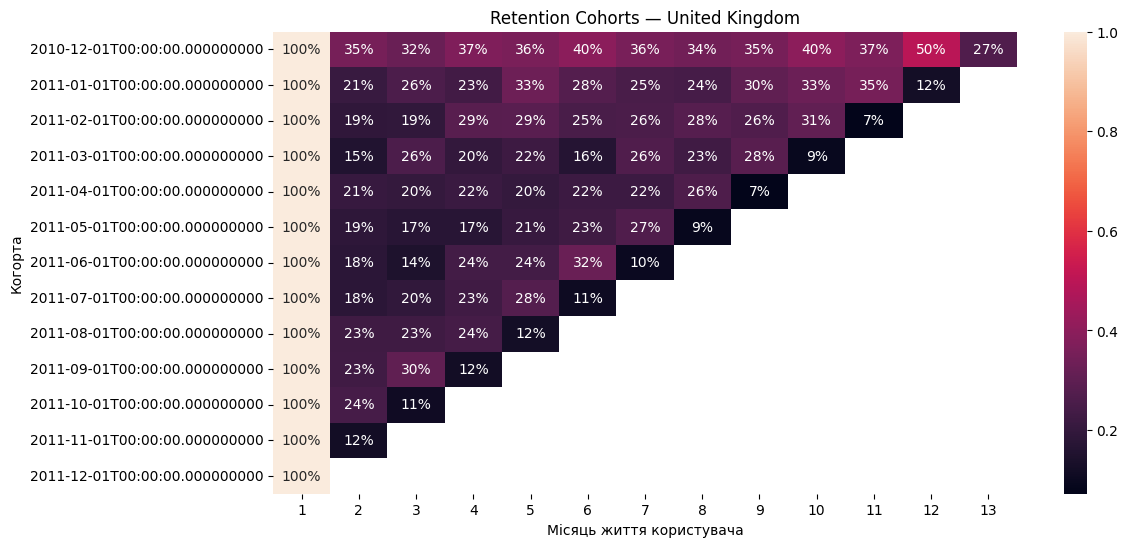

In [43]:
# Будуємо heatmap 'United Kingdom'
plt.figure(figsize=(12, 6))
sns.heatmap(
    retention_geo.loc['United Kingdom'],
    annot=True,
    fmt=".0%",

)
plt.title("Retention Cohorts — United Kingdom")
plt.xlabel("Місяць життя користувача")
plt.ylabel("Когорта")
plt.show()


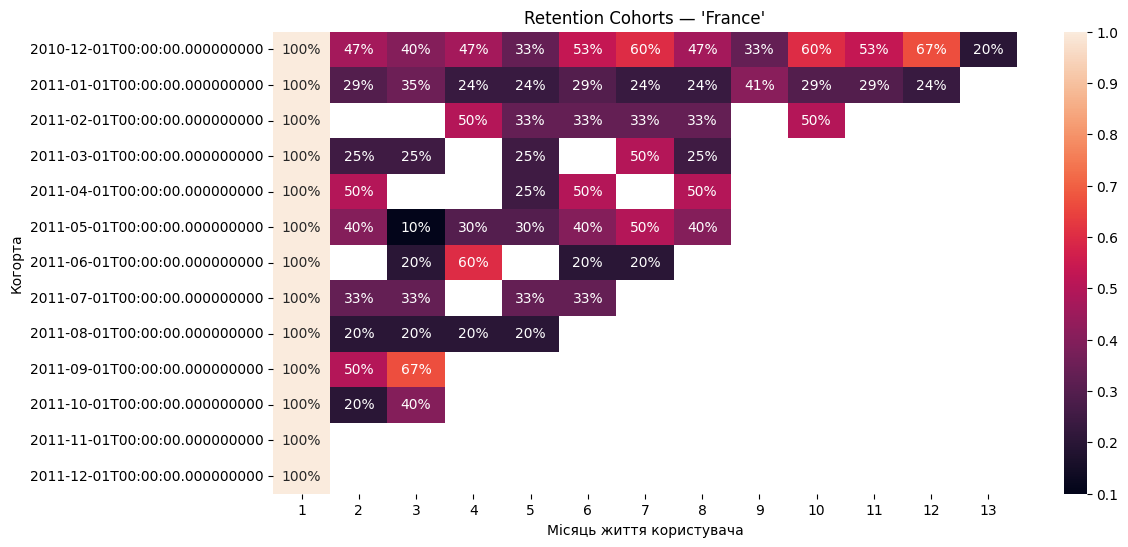

In [40]:
# Будуємо heatmap 'France'
plt.figure(figsize=(12, 6))
sns.heatmap(
    retention_geo.loc['France'],
    annot=True,
    fmt=".0%",

)
plt.title("Retention Cohorts — 'France'")
plt.xlabel("Місяць життя користувача")
plt.ylabel("Когорта")
plt.show()


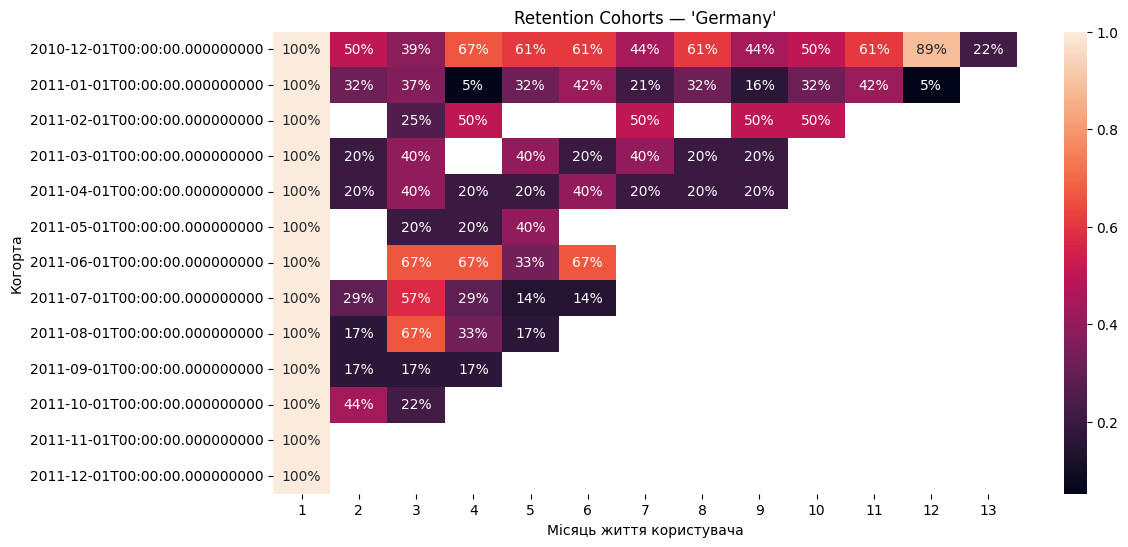

In [41]:
# Будуємо heatmap 'Germany'
plt.figure(figsize=(12, 6))
sns.heatmap(
    retention_geo.loc['Germany'],
    annot=True,
    fmt=".0%",

)
plt.title("Retention Cohorts — 'Germany'")
plt.xlabel("Місяць життя користувача")
plt.ylabel("Когорта")
plt.show()

# Звіт:1. Опис вибірки


1. Для аналізу було відібрано 10 країн з найбільшою кількістю транзакцій:
Країни у вибірці:
United Kingdom,Germany, France, EIRE, Spain, Netherlands, Belgium, Switzerland, Portugal, Australia

Ринок United Kingdom домінує — понад 90% усіх транзакцій у вибірці. Інші країни мають значно менший обсяг даних, що важливо враховувати при інтерпретації retention.

2. Методологія когортного аналізу
CohortMonth — місяць першої покупки клієнта
CohortIndex — номер місяця від моменту першої покупки
Retention — частка клієнтів, які здійснили повторну покупку у відповідному місяці життя
Retention розраховано як:
кількість активних клієнтів у місяці n / кількість клієнтів у місяці першої покупки

3. Загальні спостереження по retention-матриці
3.1 Перший місяць (CohortIndex = 1)
Для всіх когорт retention дорівнює 100%, що є очікуваним результатом
(усі клієнти здійснюють першу покупку у місяці входу).

3.2 Retention у 2–3 місяці
У більшості когорт retention у 2-й місяць коливається в межах 15–25%
Це означає, що лише кожен 4–6 клієнт повертається протягом наступного місяця
Для деяких ранніх когорт (2010-12, 2011-01) спостерігається відносно вищий рівень повернень

Приклад:
Cohort 2010-12 → ~36% у 2-й місяць
Cohort 2011-03 → ~15% у 2-й місяць

3.3 Середньостроковий retention (4–6 місяців)
Для ранніх когорт (кінець 2010 — початок 2011) retention стабілізується на рівні 20–30%
Видно, що частина клієнтів формує стійку повторну поведінку
У пізніших когорт значення нижчі або відсутні через недостатній часовий горизонт

3.4 Довгостроковий retention (9–12 місяців)
Дані доступні лише для ранніх когорт
У когортах 2010-12 та 2011-01 зберігається 10–20% активних клієнтів через рік
Це вказує на наявність лояльного ядра клієнтів

4. Особливості та обмеження аналізу
Дисбаланс за країнами
United Kingdom має значно більшу вибірку, тому його retention є найбільш надійним
Для інших країн результати можуть бути менш стабільними
NaN у retention-матриці
Відсутні значення у пізніх CohortIndex пов’язані не з відтоком клієнтів, а з тим, що відповідні місяці ще не настали

Сезонність
Когорти кінця року (2010-12) демонструють вищий довгостроковий retention, що може бути пов’язано з сезонними покупками

5. Ключові висновки
Більшість клієнтів здійснює одноразову покупку
15–30% клієнтів повертаються у коротко- та середньостроковій перспективі
Існує стійка група лояльних клієнтів, які залишаються активними протягом року
Основний бізнес-ефект формується на ринку United Kingdom

6. Рекомендовані наступні кроки
Побудувати retention окремо для кожної країни та порівняти з UK
Додати RFM-аналіз, щоб знайти сегмент лояльних клієнтів
Проаналізувати середній чек і частоту покупок для клієнтів з високим retention
Перевірити вплив сезонності та промо-періодів

## Звіт в цифрах

📊 Cohort & Retention Analysis — Quantitative Insights
1️⃣ Розподіл даних за країнами (кількісно)
У вибірці проаналізовано 10 країн
Загальна кількість транзакцій у вибірці: ~377 000

United Kingdom формує ≈ 92,5% усіх транзакцій

Країна	Транзакції	Частка
United Kingdom	349 203	92,5%
Germany	9 025	2,4%
France	8 326	2,2%
EIRE	7 226	1,9%
Інші 6 країн	3 344	1,0%

📌 Висновок:
Retention-метрики найбільш статистично надійні для United Kingdom.
2️⃣ Retention у перші місяці після першої покупки
🔹 2-й місяць (CohortIndex = 2)
Retention коливається в межах 15% – 37%
Середнє значення по когортах: ≈ 22%

Приклади:
Cohort 2010-12 → 36,7%
Cohort 2011-01 → 22,1%
Cohort 2011-03 → 15,2%

📌 У середньому лише 1 із 5 клієнтів повертається в наступному місяці.
🔹 3-й місяць (CohortIndex = 3)
Retention: 17% – 33%
Середнє: ≈ 24%

📌 Частина клієнтів повертається не одразу, а через 2 місяці після першої покупки.
3️⃣ Середньострокове утримання (4–6 місяців)
Retention стабілізується на рівні 20% – 30%
Найвищі значення спостерігаються у ранніх когорт (2010-12, 2011-01)

Приклад (Cohort 2010-12):
4-й місяць → 38,5%
6-й місяць → 40,2%

📌 Це свідчить про формування ядра постійних клієнтів.
4️⃣ Довгостроковий retention (9–12 місяців)
Доступний лише для ранніх когорт.
Cohort 2010-12:
9-й місяць → 35,7%
12-й місяць → 50,5%
13-й місяць → 26,6%

📌 Незважаючи на загальний спад, 10–20% клієнтів залишаються активними протягом року.
5️⃣ Динаміка по когортах (кількісний висновок)
Когорти кінця 2010 – початку 2011 року демонструють:
вищий початковий retention (+10–15 п.п.)
кращу довгострокову стабільність
Когорти другої половини 2011 року:
мають менше доступних місяців
показують нижчий retention у перші 2–3 місяці (≈ 11–18%)
6️⃣ Узагальнений кількісний висновок
≈ 75–85% клієнтів не повертаються після першої покупки
≈ 20–30% клієнтів формують повторні покупки у перші 3–6 місяців
≈ 10–20% клієнтів складають довгострокове лояльне ядро
Основний бізнес-ефект сконцентрований у United Kingdom
7️⃣ Бізнес-інтерпретація (з цифрами)
Дані свідчать про транзакційно орієнтовану модель з високим первинним відтоком клієнтів. При цьому приблизно кожен п’ятий клієнт повертається у середньостроковій перспективі, а близько 10–20% формують стабільну базу повторних покупців, що створює основу для програм лояльності та повторних продажів.

📌 Висновки з cohort & retention analysis (Germany, France, United Kingdom)

1️⃣ Загальна картина (ключовий висновок)

Для всіх трьох країн характерна висока первинна втрата клієнтів після першої покупки та формування невеликого, але стабільного ядра лояльних клієнтів.
У середньому 70–85% клієнтів не повертаються після першого місяця
15–30% клієнтів здійснюють повторні покупки у 2–4 місяцях
≈10–20% залишаються активними у довгостроковій перспективі (6+ місяців)

2️⃣ United Kingdom — найбільш стабільний і прогнозований ринок
Кількісні спостереження:
Retention у 2-й місяць: 18–35%
Retention у 3–6 місяцях: стабільно 20–30%
Довгостроковий retention (10–12 місяців): 7–12%

Інтерпретація:
Поведінка клієнтів у UK є найбільш рівномірною
Немає різких стрибків → велика база клієнтів згладжує флуктуації
Саме UK формує основне лояльне ядро бізнесу

📌 Висновок:
United Kingdom — зрілий ринок із передбачуваним customer lifecycle.
3️⃣ Germany — нестабільний retention через малий розмір когорт
Кількісні спостереження:
Retention у 2-й місяць: 20–50%
У деяких когорт спостерігаються піки:
до 60–90% у пізніх місяцях
Різкі “стрибки” між місяцями

Інтерпретація:
Високі значення retention не означають кращу лояльність
Це наслідок малих когорт, де навіть 1–2 клієнти суттєво впливають на %
Поведінка клієнтів менш передбачувана

📌 Висновок:
Germany — ринок з обмеженою вибіркою, результати retention слід інтерпретувати обережно.
4️⃣ France — середній профіль між UK та Germany
Кількісні спостереження:
Retention у 2-й місяць: 25–47%
У 3–6 місяцях: 20–40%
Довгостроковий retention: ≈20–25% для ранніх когорт

Інтерпретація:
Менш стабільний, ніж UK
Менше аномальних піків, ніж у Germany
Є ознаки формування повторної купівельної поведінки

📌 Висновок:
France — потенційно перспективний ринок, але з меншою клієнтською базою, ніж UK.
5️⃣ Порівняльний підсумок
Країна	Retention (2-й міс.)	Стабільність	Інтерпретація
United Kingdom	18–35%	⭐⭐⭐⭐	зрілий, стабільний
France	25–47%	⭐⭐⭐	середній
Germany	20–50%	⭐⭐	нестабільний (малі когорти)
6️⃣ Бізнес-висновок (ключовий)

Бізнес має транзакційно орієнтовану модель з високим первинним відтоком клієнтів. Основна цінність формується за рахунок обмеженого сегмента лояльних клієнтів, зосередженого переважно на ринку United Kingdom. Для інших країн спостереження обмежені меншим розміром когорт, що ускладнює інтерпретацію retention-метрик.

In [ ]:
# Revenue/LTV
# revenue_geo = pd.pivot_table(
#     df_geo,
#     index=["Country", "CohortMonth"],
#     columns="CohortIndex",
#     values="Revenue",
#     aggfunc="sum"
# )
# revenue_geo

KeyError: 'Revenue'

In [37]:
# ARPU
# arpu_geo = revenue_geo.divide(cohort_counts_geo, axis=0)
# arpu_geo

In [38]:
# LTV
# ltv_geo = arpu_geo.cumsum(axis=1)
# ltv_geo